In [2]:
import argparse, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl import graph_index
from dgl.graph_index import disjoint_partition
from dgl.data import citation_graph, CoraFull, RedditDataset
from dgl.data import AmazonCoBuy, Coauthor
from dgl.contrib.data import load_data
import math
from cacheout import Cache,LRUCache,MRUCache,LFUCache,FIFOCache,LIFOCache,RRCache
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Cora = citation_graph.load_cora()
#PubMed = citation_graph.load_pubmed()
#Nell   = citation_graph.load_nell_0_001()
#CoraFull = CoraFull()

#Reddit = RedditDataset(self_loop=True)
#Enwiki = citation_graph.load_RMAT('enwiki',100,10)
#Amazon = citation_graph.load_RMAT('amazon',100,10)
#_21M = citation_graph.load_RMAT('21',100,10)
#_22M = citation_graph.load_RMAT('22',50,10)
#_23M = citation_graph.load_RMAT('23',16,10)

Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Finished data loading and preprocessing.
  NumNodes: 65755
  NumEdges: 251550
  NumFeats: 5414
  NumClasses: 210
  NumTrainingSamples: 105
  NumValidationSamples: 500
  NumTestSamples: 969


In [4]:
DatasetList = [Cora, PubMed, Nell, CoraFull]

In [7]:
Total_size = 2048
PrecentList = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
for d in DatasetList:
    Hit = []
    g = DGLGraph(d.graph)
    degree = g.in_degrees()+g.out_degrees()
    degree_sort = [i[0] for i in sorted(enumerate(degree), key=lambda x: x[1], reverse=True)]
    partition_size = 32
    Node_index = []
    Edge = []
    Edge_number = []
    partition_number = math.ceil(g.number_of_nodes() / partition_size)
    print("the graph split to {:d} part". format(partition_number))
    for node_id in range(partition_number):
        #print(node_id)
        if node_id == partition_number-1:
            index = list(range(partition_size*node_id,g.number_of_nodes()))
        else:
            index = list(range(partition_size*node_id,partition_size*(node_id+1)))
        Node_index.append(index)
        src, dst = g.out_edges(index)
        Edge.append(list(zip(src.tolist(),dst.tolist())))
        Edge_number.append(src.shape[0])
    for pre in PrecentList:
        Degree_size = int(Total_size*pre)
        Size = Total_size - Degree_size
        Degree = Cache(Degree_size)
        LRU = LRUCache(maxsize=Size)
        MRU = MRUCache(maxsize=Size)
        LFU = LFUCache(maxsize=Size)
        FIFO = FIFOCache(maxsize=Size)
        LIFO = LIFOCache(maxsize=Size)
        RR   = RRCache(maxsize = Size)
        #CacheList = [LRU, MRU, LFU, FIFO, LIFO, RR]
        CacheList = [LFU]
        for cache in CacheList:
            cache_hit = 0
            cache_miss = 0
            if Degree_size:
                for id_ in degree_sort[0:Degree_size-1]:
                    Degree.set(id_, id_)
            for e in Edge:
                for val_ in e:
                    src, dst = val_
                    if Degree.has(dst) or cache.has(dst):
                        cache_hit = cache_hit + 1
                    else:
                        cache.set(dst, dst)
                        cache_miss = cache_miss + 1
        print('{}-{}-{}-hit={}, miss={}'.format(d.name, pre, cache.__class__, cache_hit, cache_miss))

the graph split to 85 part
cora-0-<class 'cacheout.lfu.LFUCache'>-hit=7353, miss=3203
cora-0.1-<class 'cacheout.lfu.LFUCache'>-hit=7557, miss=2999
cora-0.2-<class 'cacheout.lfu.LFUCache'>-hit=7772, miss=2784
cora-0.3-<class 'cacheout.lfu.LFUCache'>-hit=7984, miss=2572
cora-0.4-<class 'cacheout.lfu.LFUCache'>-hit=8196, miss=2360
cora-0.5-<class 'cacheout.lfu.LFUCache'>-hit=8419, miss=2137
cora-0.6-<class 'cacheout.lfu.LFUCache'>-hit=8655, miss=1901
cora-0.7-<class 'cacheout.lfu.LFUCache'>-hit=8877, miss=1679
cora-0.8-<class 'cacheout.lfu.LFUCache'>-hit=9166, miss=1390
cora-0.9-<class 'cacheout.lfu.LFUCache'>-hit=9413, miss=1143
cora-1.0-<class 'cacheout.lfu.LFUCache'>-hit=9895, miss=661
the graph split to 617 part
pubmed-0-<class 'cacheout.lfu.LFUCache'>-hit=34709, miss=53942
pubmed-0.1-<class 'cacheout.lfu.LFUCache'>-hit=35046, miss=53605
pubmed-0.2-<class 'cacheout.lfu.LFUCache'>-hit=35579, miss=53072
pubmed-0.3-<class 'cacheout.lfu.LFUCache'>-hit=36450, miss=52201
pubmed-0.4-<class '

the graph split to 85 part
cora-32-hit=1109, miss=9447
cora-64-hit=1601, miss=8955
cora-128-hit=2289, miss=8267
cora-256-hit=3282, miss=7274
cora-512-hit=4755, miss=5801
cora-1024-hit=6990, miss=3566
cora-2048-hit=9719, miss=837
cora-4096-hit=10556, miss=0
cora-8192-hit=10556, miss=0
cora-16384-hit=10556, miss=0
the graph split to 617 part
pubmed-32-hit=2620, miss=86031
pubmed-64-hit=4411, miss=84240
pubmed-128-hit=7290, miss=81361
pubmed-256-hit=11882, miss=76769
pubmed-512-hit=18992, miss=69659
pubmed-1024-hit=29523, miss=59128
pubmed-2048-hit=44269, miss=44382
pubmed-4096-hit=61039, miss=27612
pubmed-8192-hit=74693, miss=13958
pubmed-16384-hit=85317, miss=3334
the graph split to 2055 part
nell.0.001-32-hit=47745, miss=203805
nell.0.001-64-hit=69022, miss=182528
nell.0.001-128-hit=92110, miss=159440
nell.0.001-256-hit=112547, miss=139003
nell.0.001-512-hit=123692, miss=127858
nell.0.001-1024-hit=131968, miss=119582
nell.0.001-2048-hit=141692, miss=109858
nell.0.001-4096-hit=154043, m

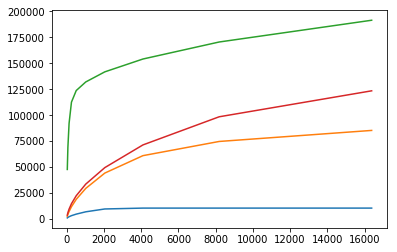

In [5]:
Total_size = [32,64,128,256,512,1024,2048,4096,8192,16384]
for d in DatasetList:
    Hit = []
    g = DGLGraph(d.graph)
    degree = g.in_degrees()+g.out_degrees()
    degree_sort = [i[0] for i in sorted(enumerate(degree), key=lambda x: x[1], reverse=True)]
    partition_size = 32
    Node_index = []
    Edge = []
    Edge_number = []
    partition_number = math.ceil(g.number_of_nodes() / partition_size)
    print("the graph split to {:d} part". format(partition_number))
    for node_id in range(partition_number):
        #print(node_id)
        if node_id == partition_number-1:
            index = list(range(partition_size*node_id,g.number_of_nodes()))
        else:
            index = list(range(partition_size*node_id,partition_size*(node_id+1)))
        Node_index.append(index)
        src, dst = g.out_edges(index)
        Edge.append(list(zip(src.tolist(),dst.tolist())))
        Edge_number.append(src.shape[0])
    for pre in Total_size:
        Degree = Cache(pre)
        cache_hit = 0
        cache_miss = 0
        for id_ in degree_sort[0:pre-1]:
            Degree.set(id_, id_)
        for e in Edge:
            for val_ in e:
                src, dst = val_
                if Degree.has(dst):
                    cache_hit = cache_hit + 1
                else:
                    cache_miss = cache_miss + 1
        print('{}-{}-hit={}, miss={}'.format(d.name, pre, cache_hit, cache_miss))
        Hit.append(cache_hit)
    plt.plot(Total_size,Hit)
    #write_path = './{}_log.txt'.format(d.name)
    #with open(write_path, 'w') as output:
    #    for id_, value in enumerate(Hit):
    #        output.write(str(Total_size[id_])+','+str(value)+'\t\n')
        
plt.show()

In [17]:
data = load_data(args)
n_edges = data.graph.number_of_edges()
g = DGLGraph(data.graph)
degree = g.in_degrees()+g.out_degrees()
degree_sort = [i[0] for i in sorted(enumerate(degree), key=lambda x: x[1], reverse=True)]
degree_cache_value = [list() for _ in range(32)]
for val_ in degree_sort:
    degree_cache_value[val_%32].append(val_)

In [18]:
partition_size = 32
Node_index = []
Edge = []
Edge_number = []
partition_number = math.ceil(g.number_of_nodes() / partition_size)
print("the graph split to {:d} part". format(partition_number))
for node_id in range(partition_number):
    #print(node_id)
    if node_id == partition_number-1:
        index = list(range(partition_size*node_id,g.number_of_nodes()))
    else:
        index = list(range(partition_size*node_id,partition_size*(node_id+1)))
    Node_index.append(index)
    src, dst = g.out_edges(index)
    Edge.append(list(zip(src.tolist(),dst.tolist())))
    Edge_number.append(src.shape[0])

the graph split to 619 part


In [19]:
Total_size = [32,64,128,256,512,1024,2048,4096,8192,16384]
PrecentList = [1]
Hit = []
for pre in Total_size:
    Degree = Cache(pre)
    #CacheList = [LRU, MRU, LFU, FIFO, LIFO, RR]
    cache_hit = 0
    cache_miss = 0
    for id_ in degree_sort[0:pre-1]:
        Degree.set(id_, id_)
    for e in Edge:
        for val_ in e:
            src, dst = val_
            if Degree.has(dst):
                cache_hit = cache_hit + 1
            else:
                cache_miss = cache_miss + 1
    Hit.append(cache_hit)
    print('{}-hit={}, miss={}'.format(pre, cache_hit, cache_miss))

32-hit=3835, miss=123007
64-hit=6157, miss=120685
128-hit=9591, miss=117251
256-hit=14778, miss=112064
512-hit=22465, miss=104377
1024-hit=33653, miss=93189
2048-hit=49521, miss=77321
4096-hit=71364, miss=55478
8192-hit=98450, miss=28392
16384-hit=123432, miss=3410
